# Gaussian process - DoH 2
After finding the correct feeding profile \\

===Logic=== \\ 
After t> T_Start*24 hrs, F ml of feed is added every 24 hours, as long as the volume is less than 51 ml. \\
If the difference between the current volume and 51 ml if less than F, only the ddifference is added (to make the volume 51 ml).\\
Once 51 ml is reached, the feed is stopped.
Every 24 hrs from the start of the process, 1 ml is taken out for sampling.

In [1]:
import torch
import gpytorch
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.optimize import least_squares
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [2]:
# Load Excel file
data = pd.read_excel("Exp1_4.xlsx", engine="openpyxl")

# Preview column names
print("Columns:", data.columns)

# Filter data for each batch
batches1_4 = {}
for i in range(1, 5):
    batches1_4[i] = data[data['ID'] == i].copy()
    batches1_4[i]['CDW [g/L]'] = batches1_4[i]['Xv [ cells/L]']*300e-12  # Convert cells to g/L]


Columns: Index(['ID', 'time [h]', 'Xv [ cells/L]', 'Xd [cells/L]', 'Xt [cells/L]',
       'cglc [mM]', 'cgln [mM]', 'clac [mM]', 'camm [mM]', 'cAb [mg/L]',
       'V [L]', 'Viability'],
      dtype='object')


In [3]:
# Load Excel file
data = pd.read_excel("Exp5_33.xlsx", engine="openpyxl")

# Preview column names
print("Columns:", data.columns)

# Filter data for each batch
batches5_33 = {}
for i in range(5, 34):
    batches5_33[i] = data[data['ID'] == i].copy()
    batches5_33[i]['CDW [g/L]'] = batches5_33[i]['Xv [ cells/L]']*300e-12  # Convert cells to g/L]

Columns: Index(['ID', 'time [h]', 'Xv [ cells/L]', 'Xd [cells/L]', 'Xt [cells/L]',
       'cglc [mM]', 'cgln [mM]', 'clac [mM]', 'camm [mM]', 'cAb [mg/L]',
       'V [L]', 'Viability'],
      dtype='object')


In [4]:
batches = batches1_4.copy()
batches.update(batches5_33)
print(len(batches), "batches loaded.")

33 batches loaded.


In [5]:
for batch_id, df in batches.items():
    # Keep only rows where 'time [h]' is an integer and <= 264
    df_rep = df[(df['time [h]']%24 ==0) & (df['time [h]'] <= 264.1)]
    # df_rep = df_rep.reset_index(drop = True, inplace = True)
    batches[batch_id] = df_rep

In [6]:
PROCESS_CONDITIONS = pd.read_excel('Process conditions.xlsx')
PROCESS_CONDITIONS.head()

,Exp,cGlcF [mmol l-1],cGlnF [mmol l-1],F [ml day-1],Feed start [days]
0,1,222,9,2.5,4
1,2,222,12,4.0,2
2,3,222,38,4.0,3
3,4,222,9,1.0,3
4,5,222,9,4.3,3


## Split train and test batches

In [7]:
operational_extrapolation_batchIDs = [4, 33]
initial_conc_extrapolation_batchIDs = [2,3,4,27]
ignore_batchIDs = [1]

In [8]:
for batch_id, df in batches.items():
    # print(f"Batch ID: {batch_id}")
    # print(df.head())
    initial_glc = df.iloc[0]['cglc [mM]']
    if initial_glc > 50 or initial_glc < 42:
        print(f"Batch ID {batch_id}: Initial glucose = {initial_glc}")

Batch ID 1: Initial glucose = 40.0
Batch ID 2: Initial glucose = 40.0
Batch ID 3: Initial glucose = 40.0
Batch ID 4: Initial glucose = 40.0
Batch ID 27: Initial glucose = 51.242111572800674


In [9]:


# Remove ignored and extrapolation batches from the set of all batch IDs
all_batch_ids = set(batches.keys())
ignore_set = set(ignore_batchIDs)
operational_set = set(operational_extrapolation_batchIDs)
initial_conc_set = set(initial_conc_extrapolation_batchIDs)

# Remove ignored and extrapolation batch IDs
eligible_ids = all_batch_ids - ignore_set - operational_set - initial_conc_set

# Split eligible batches into train and intrapolation test (90%/10%)
eligible_ids = sorted(list(eligible_ids))
train_ids, intrapolation_test_ids = train_test_split(
    eligible_ids, test_size=0.1, random_state=42
)

# For clarity, convert all to sorted lists
operational_extrapolation_ids = sorted(list(operational_set))
initial_conc_extrapolation_ids = sorted(list(initial_conc_set))
train_ids = sorted(train_ids)
intrapolation_test_ids = sorted(intrapolation_test_ids)

train_batches = {id: batches[id] for id in train_ids}
intrapolation_test_batches = {id: batches[id] for id in intrapolation_test_ids}
operational_extrapolation_batches = {id: batches[id] for id in operational_extrapolation_ids}
initial_conc_extrapolation_batches = {id: batches[id] for id in initial_conc_extrapolation_ids}

print("Train batch IDs:", train_ids)
print("Intrapolation test batch IDs:", intrapolation_test_ids)
print("Operational extrapolation batch IDs:", operational_extrapolation_ids)
print("Initial concentration extrapolation batch IDs:", initial_conc_extrapolation_ids)

Train batch IDs: [5, 6, 7, 8, 9, 10, 11, 12, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32]
Intrapolation test batch IDs: [13, 14, 18]
Operational extrapolation batch IDs: [4, 33]
Initial concentration extrapolation batch IDs: [2, 3, 4, 27]


In [10]:
def get_process_conditions_dict(batch_ids):
    return {bid: PROCESS_CONDITIONS[PROCESS_CONDITIONS['Exp'] == bid].iloc[0].to_dict()
            for bid in batch_ids if bid in PROCESS_CONDITIONS['Exp'].values}

In [11]:
# Create dictionaries mapping batch ID to process conditions for each category

# Ensure PROCESS_CONDITIONS has 'ID' as integer for matching
PROCESS_CONDITIONS['Exp'] = PROCESS_CONDITIONS['Exp'].astype(int)

def get_process_conditions_dict(batch_ids):
    return {bid: PROCESS_CONDITIONS[PROCESS_CONDITIONS['Exp'] == bid].iloc[0].to_dict()
            for bid in batch_ids if bid in PROCESS_CONDITIONS['Exp'].values}

train_conditions = get_process_conditions_dict(train_ids)
intrapolation_test_conditions = get_process_conditions_dict(intrapolation_test_ids)
operational_extrapolation_conditions = get_process_conditions_dict(operational_extrapolation_ids)
initial_conc_extrapolation_conditions = get_process_conditions_dict(initial_conc_extrapolation_ids)

In [12]:
#print the first few entries of each dictionary
print("Train conditions sample:", {k: train_conditions[k] for k in list(train_conditions)[:3]})

Train conditions sample: {5: {'Exp': 5.0, 'cGlcF [mmol l-1]': 222.0, 'cGlnF [mmol l-1]': 9.0, 'F [ml day-1]': 4.3, 'Feed start [days]': 3.0}, 6: {'Exp': 6.0, 'cGlcF [mmol l-1]': 111.0, 'cGlnF [mmol l-1]': 21.0, 'F [ml day-1]': 6.0, 'Feed start [days]': 2.0}, 7: {'Exp': 7.0, 'cGlcF [mmol l-1]': 192.0, 'cGlnF [mmol l-1]': 18.0, 'F [ml day-1]': 6.0, 'Feed start [days]': 3.0}}


In [13]:
# function to compute reaction rate from x_state (state at time t) and y_state (state at time t+1), along with feed volume and feed concentrations
def compute_specific_reaction_rate(x_state, y_state, feed_volume, feed_conc):
    [cdw_x, glc_x, gln_x, lc_x, amm_x, Ab_x, vol_x] = x_state
    [cdw_y, glc_y, gln_y, lc_y, amm_y, Ab_y, vol_y] = y_state
    [glc_f, gln_f] = feed_conc
    sample_v = 0.001 # 1 mL sample volume
    vol_current = vol_x - sample_v
    total_mass_x = x_state[:-1] * vol_current  # Exclude volume from total mass
    #compute mass added by feed
    glc_feed_mass = glc_f * feed_volume
    gln_feed_mass = gln_f * feed_volume
    # mass at y = mass at x  + mass from feed + mass from reaction
    total_mass_y = y_state[:-1] * vol_y  # Exclude volume from total mass
    feed_mass = np.array([0, glc_feed_mass, gln_feed_mass, 0, 0, 0])
    reaction_mass = total_mass_y - total_mass_x - feed_mass
    specific_reaction = reaction_mass / (cdw_x*vol_y)  # specific Reaction rate 
    assert round(vol_current + feed_volume, 4) == round(vol_y, 4) , "Volume mismatch: vol_current + feed_volume should equal vol_y, but got {} + {} != {}".format(vol_current, feed_volume, vol_y)
    return specific_reaction 


Batch ID: 5
Process conditions: [222.    9.    3.    4.3]
Feed volume (L/day): 0.0043
Feed start time (h): 72.0
Feed glucose concentration (mM): 222.0
Feed glutamine concentration (mM): 9.0
vol tracker triggered at time 216.0 hrs. Feed volume is now 0.004200000000000009 L 
Volume at time 216.0 hrs: 0.04679999999999999 L
Volume at time 216.0 hrs + Feed volume: 0.051099999999999986 L


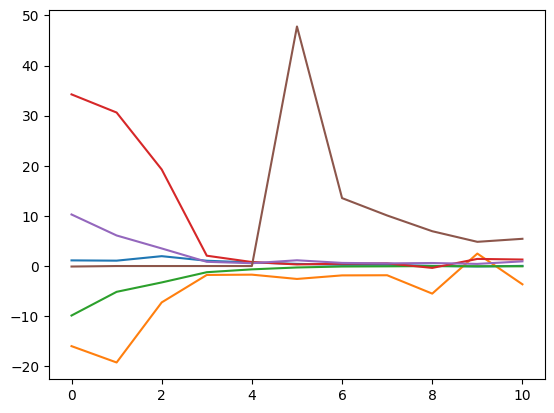

In [14]:
process_cond_cols = ['cGlcF [mmol l-1]', 'cGlnF [mmol l-1]', 'Feed start [days]', 'F [ml day-1]']
state_vars = ['CDW [g/L]', 'cglc [mM]', 'cgln [mM]', 'clac [mM]', 'camm [mM]', 'cAb [mg/L]', 'V [L]']
X_list = []
Y_list = []
sampling_vol = 0.001  # 1 mL sample volume
debugging =True
for batch_id, batch_df in train_batches.items():
    # Prepare training data
    if batch_df.empty:
        continue
    # Get batch id
    batch_id = int(batch_df['ID'].iloc[0])
    # Get process conditions for this batch
    cond_row = PROCESS_CONDITIONS[PROCESS_CONDITIONS['Exp'].astype(int) == batch_id]
    if cond_row.empty:
        print(f"No process conditions found for batch {batch_id}, skipping.")
        continue
    # print(cond_row)
    cond_values = cond_row.iloc[0][process_cond_cols].values.astype(float)
    # print('batch: \n', batch_df.head())
    batch_df = batch_df.reset_index(drop=True)
    Feed_vol = cond_values[3]*0.001  # Feed volume in L/day
    feed_start_time = cond_values[2]*24  # Feed start time in hours
    feed_glc = cond_values[0]   # Feed glucose concentration in mM
    feed_gln = cond_values[1]   # Feed glutamine concentration in mM
    
    # Debugging prints
    if debugging is True:
        print(f"Batch ID: {batch_id}")
        print("Process conditions:", cond_values)
        print("Feed volume (L/day):", Feed_vol)
        print("Feed start time (h):", feed_start_time)
        print("Feed glucose concentration (mM):", feed_glc)
        print("Feed glutamine concentration (mM):", feed_gln)


    # For each time point except the last, create X and Y
    vol_tracker = False
    for i in range(len(batch_df) - 1):
        x_state = batch_df.loc[i, state_vars].values.astype(float)
        # print(batch_df.loc[i, state_vars].values.astype(float))
        x_time = batch_df.loc[i, 'time [h]']
        current_vol = x_state[-1]  # Current volume in L
        
        y_state = batch_df.loc[i + 1, state_vars].values.astype(float)
        current_feed = 0
        # compute feed volume and concentrations
        if x_time>= feed_start_time:
            if vol_tracker == True:
                current_feed = 0
            elif current_vol + Feed_vol  > 0.051 :
                current_feed = 0.051- current_vol
                vol_tracker = True
                if debugging is True:
                    print(f'vol tracker triggered at time {x_time} hrs. Feed volume is now {current_feed} L ')
                    print(f'Volume at time {x_time} hrs: {x_state[-1]} L')
                    print(f'Volume at time {x_time} hrs + Feed volume: {x_state[-1] + Feed_vol} L')
            else:
                current_feed = Feed_vol
        x = np.concatenate([x_state, [current_feed], [feed_glc, feed_gln], [x_time]])
        X_list.append(x)
        reaction_rates = compute_specific_reaction_rate(x_state, y_state, 
                                               current_feed, [feed_glc, feed_gln])
        Y_list.append(reaction_rates)
    if debugging is True:
        #plot reaction rates for this batch
        # fig, axes = plt.subplots(len(state_vars)//3, 3, figsize=(18, 10))
        plt.plot(Y_list, label='Reaction Rates')       
        debugging = False 
X = np.array(X_list)
Y = np.array(Y_list)
# X contains: ['CDW [g/L]', 'cglc [mM]', 'cgln [mM]', 'clac [mM]', 'camm [mM]', 'cAb [mg/L]', 'V [L]', current_feed, feed_glc, feed_gln, 'time [h]']
# Y contains reaction rates for: # ['CDW [g/L]', 'cglc [mM]', 'cgln [mM]', 'clac [mM]', 'camm [mM]', 'cAb [mg/L]']

In [15]:
# Define GP model
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_tasks):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=num_tasks
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()),
            num_tasks=num_tasks,
            rank=1
        ) + gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()),
            num_tasks=num_tasks,
            rank=1
        )
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

# Wrapper for training a multi-output GP model
def train_gp_model(X, Y, num_epochs=100):
    
    #Unpack X:
    # X contains: ['CDW [g/L]', 'cglc [mM]', 'cgln [mM]', 'clac [mM]', 'camm [mM]', 'cAb [mg/L]', 'V [L]', current_feed, feed_glc, feed_gln, 'time [h]']
    # Y contains reaction rates for: # ['CDW [g/L]', 'cglc [mM]', 'cgln [mM]', 'clac [mM]', 'camm [mM]', 'cAb [mg/L]']
    # X_state = X[:, :6]  # State variables
    X_scalar = StandardScaler()
    X_scaled = X_scalar.fit_transform(X)  # Scale state variables
    Y_scalar = StandardScaler()
    Y_scaled = Y_scalar.fit_transform(Y)  # Scale reaction rates
    train_x = torch.tensor(X_scaled, dtype=torch.float32)
    train_y = torch.tensor(Y_scaled, dtype=torch.float32)

    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=Y.shape[1])
    model = MultitaskGPModel(train_x, train_y, likelihood, num_tasks=Y.shape[1])

    model.train()
    likelihood.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(num_epochs):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()
        if i % (num_epochs/10) == 0:
            print(f"Iter {i}/{num_epochs} - Loss: {loss.item():.3f}")

    return model.eval(), likelihood.eval(), X_scalar, Y_scalar


In [16]:
trained_model, trained_likelihood, X_scalar, Y_scalar = train_gp_model(X, Y, num_epochs=100)

Iter 0/100 - Loss: 1.613
Iter 10/100 - Loss: 1.063
Iter 20/100 - Loss: 0.757
Iter 30/100 - Loss: 0.534
Iter 40/100 - Loss: 0.439
Iter 50/100 - Loss: 0.612
Iter 60/100 - Loss: 0.635
Iter 70/100 - Loss: 0.601
Iter 80/100 - Loss: 0.605
Iter 90/100 - Loss: 0.579


In [17]:
# evaluate model performance with R-sq plot
def evaluate_model_performance(model, likelihood, X, Y, X_scalar, Y_scalar):
    model.eval()
    likelihood.eval()
    state_vars = ['CDW [g/L]', 'cglc [mM]', 'cgln [mM]', 'clac [mM]', 'camm [mM]', 'cAb [mg/L]']
    with torch.no_grad():
        # Unpack X:
        # x = X[:, :6]  # State variables
        x=X_scalar.transform(X)  # Scale state variables
        test_x = torch.tensor(x, dtype=torch.float32)
        observed_pred = likelihood(model(test_x))
        mean = observed_pred.mean
        lower, upper = observed_pred.confidence_region()
        mean = Y_scalar.inverse_transform(mean.numpy())
    # Calculate R-squared for each output
    r2_scores = []
    for i in range(Y.shape[1]):
        r2 = r2_score(Y[:, i], mean[:, i])
        r2_scores.append(r2)
        print(f"R-squared for output {i}: {r2:.3f}")

    # Plot predictions vs true values
    plt.figure(figsize=(12, 8))
    for i in range(len(state_vars)):
        plt.subplot(2, 3, i + 1)
        plt.scatter(Y[:, i], mean[:, i], alpha=0.5)
        # plt.fill_between(
        #     Y[:, i], lower[:, i].numpy(), upper[:, i].numpy(), color='gray', alpha=0.5
        # )
        plt.plot([Y[:, i].min(), Y[:, i].max()], [Y[:, i].min(), Y[:, i].max()], 'k--')
        plt.title(f'Output {state_vars[i]} - R²: {r2_scores[i]:.3f}')
        plt.xlabel('True Values')
        plt.ylabel('Predicted Values')
    
    plt.tight_layout()
    plt.show()


c:\Users\rajka\AppData\Local\Programs\Python\Python312\Lib\site-packages\gpytorch\models\exact_gp.py:296: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


R-squared for output 0: 0.979
R-squared for output 1: 0.589
R-squared for output 2: 0.957
R-squared for output 3: 0.993
R-squared for output 4: 0.934
R-squared for output 5: 0.578


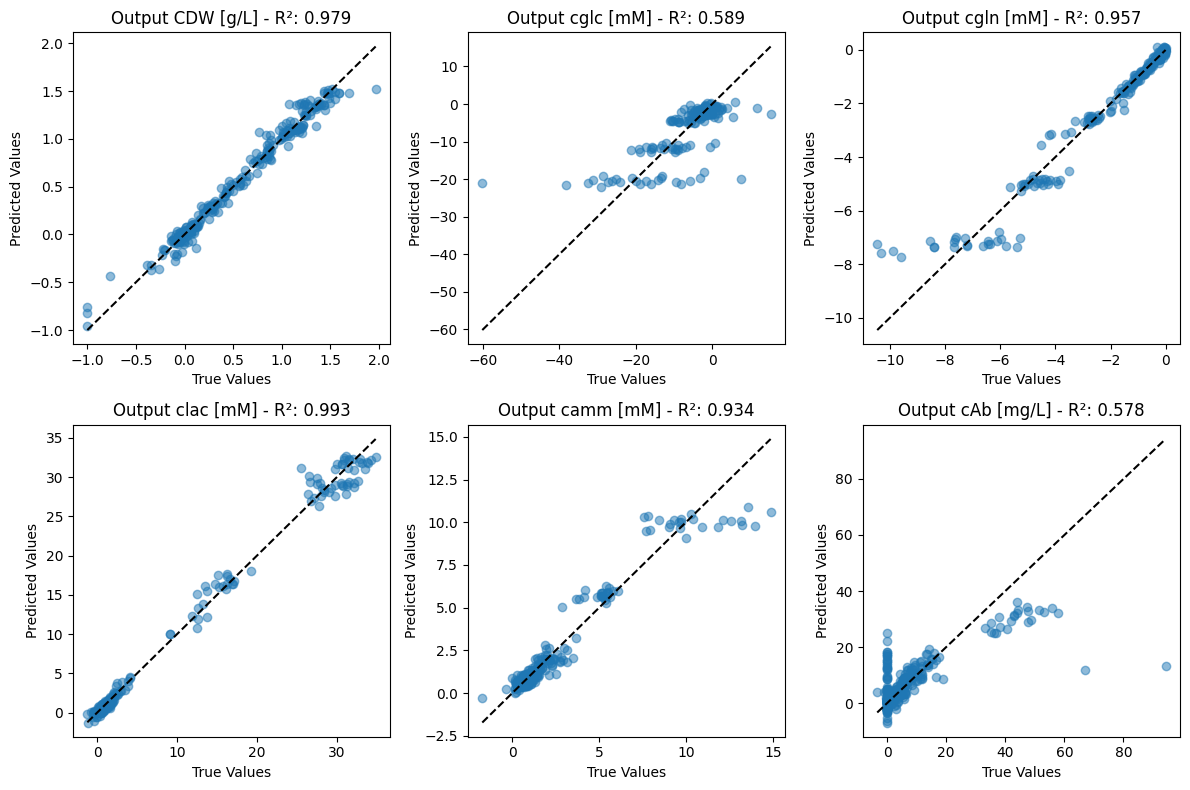

In [18]:
evaluate_model_performance(trained_model, trained_likelihood, X, Y, X_scalar, Y_scalar)

In [19]:
# # Function to compute next state given 
# # current state, feed volume, and feed concentrations, and reaction rate
# def compute_next_state(x_state, feed_volume, feed_conc, sp_reaction_rate):
#     [cdw_x, glc_x, gln_x, lc_x, amm_x, Ab_x, vol_x] = x_state
#     [glc_f, gln_f] = feed_conc
#     # Compute reaction rate
    
#     vol_y = vol_x + feed_volume   # Update volume with feed volume 
#     # Update state variables based on reaction rate and feed
#     cdw_y = (cdw_x*vol_x + sp_reaction_rate[0] *cdw_x*vol_y )/vol_y
#     glc_y = (glc_x*vol_x + sp_reaction_rate[1] *cdw_x* vol_y + glc_f * feed_volume) / vol_y
#     gln_y = (gln_x*vol_x + sp_reaction_rate[2] *cdw_x* vol_y + gln_f * feed_volume) / vol_y
#     lc_y = (lc_x*vol_x + sp_reaction_rate[3] *cdw_x* vol_y)/vol_y
#     amm_y = (amm_x*vol_x + sp_reaction_rate[4] *cdw_x* vol_y)/vol_y
#     Ab_y = (Ab_x*vol_x + sp_reaction_rate[5] *cdw_x* vol_y)/vol_y
#     vol_y = vol_y -0.001 # Subtract sample volume (1 mL) from total volume
#     # vol_y = vol_x + feed_volume  # Update volume with feed volume
    
#     return np.array([cdw_y, glc_y, gln_y, lc_y, amm_y, Ab_y, vol_y])

In [20]:
# Function to compute next state given 
# current state, feed volume, and feed concentrations, and reaction rate
def compute_next_state(x_state, feed_volume, feed_conc, sp_reaction_rate):
    [cdw_x, glc_x, gln_x, lc_x, amm_x, Ab_x, vol_x] = x_state
    [glc_f, gln_f] = feed_conc
    # Compute reaction rate
    
    vol_y = vol_x + feed_volume   # Update volume with feed volume 
    # Update state variables based on reaction rate and feed
    cdw_y = (cdw_x*vol_x + sp_reaction_rate[0] *cdw_x*vol_x )/vol_y
    glc_y = (glc_x*vol_x + sp_reaction_rate[1] *cdw_x* vol_x + glc_f * feed_volume) / vol_y
    gln_y = (gln_x*vol_x + sp_reaction_rate[2] *cdw_x* vol_x + gln_f * feed_volume) / vol_y
    # glc_y = (glc_x*vol_x + sp_reaction_rate[1] *cdw_x* vol_x ) / vol_y
    # gln_y = (gln_x*vol_x + sp_reaction_rate[2] *cdw_x* vol_x ) / vol_y
    lc_y = (lc_x*vol_x + sp_reaction_rate[3] *cdw_x* vol_x)/vol_y
    amm_y = (amm_x*vol_x + sp_reaction_rate[4] *cdw_x* vol_x)/vol_y
    Ab_y = (Ab_x*vol_x + sp_reaction_rate[5] *cdw_x* vol_x)/vol_y
    vol_y = vol_y -0.001 # Subtract sample volume (1 mL) from total volume
    # vol_y = vol_x + feed_volume  # Update volume with feed volume
    
    return np.array([cdw_y, glc_y, gln_y, lc_y, amm_y, Ab_y, vol_y])

In [21]:
# Function to make predictions with the trained model
def predict_with_gp(model, likelihood, X_new, X_scalar, Y_scalar):
    model.eval()
    likelihood.eval()
    # Unpack x:
    # X contains: ['CDW [g/L]', 'cglc [mM]', 'cgln [mM]', 'clac [mM]', 'camm [mM]', 'cAb [mg/L]', 'V [L]', current_feed, feed_glc, feed_gln, 'time [h]']
    state_vars = ['CDW [g/L]', 'cglc [mM]', 'cgln [mM]', 'clac [mM]', 'camm [mM]', 'cAb [mg/L]', 'V [L]']
    x_state = X_new[:len(state_vars)]
    current_volume = X_new[len(state_vars)-1]  # Last element is the current volume
    feed_volume = X_new[len(state_vars)]
    feed_glc = X_new[len(state_vars) + 1]
    feed_gln = X_new[len(state_vars) + 2]
    time = X_new[-1]
    with torch.no_grad():
        # print('Shape of X_new before scaling:', X_new.shape)
        X_new = X_new.reshape(1, -1)  # Ensure X_new is 2D
        # print('Shape of X_new after reshaping:', X_new.shape)
        X_new = X_scalar.transform(X_new)  # Scale the new input
        X_new_tensor = torch.tensor(X_new, dtype=torch.float32).unsqueeze(0)
        preds = likelihood(model(X_new_tensor))
        mean_reaction_rate = preds.mean.numpy().squeeze(0)
        lower, upper = preds.confidence_region()
        lower = lower.numpy().squeeze(0)
        upper = upper.numpy().squeeze(0)
        mean_reaction_rate = Y_scalar.inverse_transform(mean_reaction_rate)
        lower = Y_scalar.inverse_transform(lower)
        upper = Y_scalar.inverse_transform(upper)
    # Use compute_next_state to get the next state (mean)
    # debugging print:
    # print('Shape of mean_reaction_rate:', mean_reaction_rate.shape)
    mean_reaction_rate = mean_reaction_rate.flatten()  # Ensure it's a 1D array
    lower = lower.flatten()  # Ensure it's a 1D array
    upper = upper.flatten()  # Ensure it's a 1D array
    # print('Shape of mean_reaction_rate after flattening:', mean_reaction_rate.shape)
    next_state = compute_next_state(x_state, feed_volume, [feed_glc, feed_gln], mean_reaction_rate)
    # Use compute_next_state to get the next state (lower and upper bounds)
    next_state_lower = compute_next_state(x_state, feed_volume, [feed_glc, feed_gln], lower)
    next_state_upper = compute_next_state(x_state, feed_volume, [feed_glc, feed_gln], upper)
    return next_state, next_state_lower, next_state_upper, mean_reaction_rate
    
    

In [22]:
# Updated simulate_process_profile using multitask GP model
def simulate_process_profile(initial_state, times, process_conditions, model, likelihood, X_scalar, Y_scalar):
    state_dim = len(initial_state)
    # Unpack process conditions
    feed_glc = process_conditions['cGlcF [mmol l-1]']
    feed_gln = process_conditions['cGlnF [mmol l-1]']
    feed_start_time = process_conditions['Feed start [days]'] * 24  # Convert to hours
    Feed_vol = process_conditions['F [ml day-1]'] * 0.001  # Convert to L/day
    predicted_states = [initial_state]
    predicted_states_lower = [initial_state]
    predicted_states_upper = [initial_state]
    predicted_stds = [np.zeros_like(initial_state)]
    initial_volume = initial_state[-1]  # Last element is volume
    volumes = [initial_volume]
    vol_tracker = False
    for i in range(1, len(times)):
        dt = times[i] - times[i-1]
        current_state = predicted_states[-1]
        current_volume = volumes[-1]
        t = times[i-1]

        
        x_input = np.concatenate([current_state, [
            process_conditions['cGlcF [mmol l-1]'],
            process_conditions['cGlnF [mmol l-1]'],
            process_conditions['Feed start [days]'],
            process_conditions['F [ml day-1]'],
            t
        ]])
        # find current feed volume:
        # compute feed volume and concentrations
        
        current_feed = 0
        # compute feed volume and concentrations
        if t>= feed_start_time:
            if vol_tracker == True:
                current_feed = 0
            elif current_volume + Feed_vol  > 0.051 :
                current_feed = 0.051- current_volume
                vol_tracker = True
            else:
                current_feed = Feed_vol
        x = np.concatenate([current_state, [current_feed], [feed_glc, feed_gln], [t]])

        # Predict next state using the GP model
        next_state, lower_bound, upper_bound, mean_reaction_rate = predict_with_gp(model, likelihood, x, X_scalar, Y_scalar)

        
        predicted_states.append(next_state)
        predicted_states_lower.append(lower_bound)
        predicted_states_upper.append(upper_bound)
        
        volumes.append(next_state[-1])

    return np.array(predicted_states), np.array(predicted_states_lower), np.array(predicted_states_upper)

In [23]:
# Function to plot predicted vs actual process profiles
def plot_process_profiles(times, predicted_states, predicted_states_lower, predicted_states_upper, true_states, state_vars, title = 'Gaussian Process Hybrid Model'):
    fig, axes = plt.subplots(len(state_vars)//3, 3, figsize=(18, 10))
    for i, var in enumerate(state_vars):
        ax = axes.flatten()[i]
        ax.plot(times, true_states[:, i], label='Experimental', color='black')
        ax.plot(times, predicted_states[:, i], label='Predicted', color='blue')
        ax.fill_between(times,
                        predicted_states_lower[:, i] ,
                        predicted_states_upper[:, i] ,
                        color='blue', alpha=0.3, label='confidence interval' )
        # clip the y-axis to avoid negative values
        ax.set_ylim(bottom=0)
        ax.set_title(var)
        ax.set_xlabel("Time [h]")
        ax.set_ylabel(var)
        ax.legend()
    plt.tight_layout()
    # plt.title(title)
    plt.show()

In [24]:
# Predict complete process for a batch
def evaluate_batch_category_gp_with_uncertainty(test_batches, category_name, model, likelihood, process_conditions_dict, X_scalar, Y_scalar, idx=0, save_Data = False):
    state_vars = ['CDW [g/L]', 'cglc [mM]', 'cgln [mM]', 'clac [mM]', 'camm [mM]', 'cAb [mg/L]', 'V [L]']
    first_batch_id = list(test_batches.keys())[idx]
    df = test_batches[first_batch_id]
    times = df['time [h]'].values
    true_states = df[state_vars].values
    initial_state = true_states[0]
    # initial_volume = df['V [L]'].values[0]
    process_conditions = process_conditions_dict[first_batch_id]

    predicted_states, predicted_states_lower, predicted_states_upper = simulate_process_profile(initial_state, times, process_conditions, model, likelihood, X_scalar, Y_scalar)
    
    plot_process_profiles(times, predicted_states, predicted_states_lower, predicted_states_upper, true_states, state_vars[:-1], title = category_name) # exclude volume from plots
    mean_mse = []
    mean_nmse = []
    for i, var in enumerate(state_vars[:-1]):
        mse = mean_squared_error(true_states[:, i], predicted_states[:, i])
        nmse = mse/ np.var(true_states[:,i])
        mean_mse.append(mse)
        mean_nmse.append(nmse)
        print(f"{var} - MSE: {mse:.4f}, NMSE: {nmse}")
    print(f'Mean Mse : {np.mean(mean_mse)}, mean nmse: {np.mean(mean_nmse)}')
    if save_Data:
 
        # Example arrays (replace these with your actual data)
        # predicted_states, predicted_states_upper, predicted_states_lower, times, state_vars must be defined

        # Create DataFrames with suffixes for each type
        df_pred = pd.DataFrame(predicted_states, columns=[f"{var}_pred" for var in state_vars])
        df_upper = pd.DataFrame(predicted_states_upper, columns=[f"{var}_upper" for var in state_vars])
        df_lower = pd.DataFrame(predicted_states_lower, columns=[f"{var}_lower" for var in state_vars])

        # Combine all into a single DataFrame
        df_combined = pd.concat([pd.Series(times, name="time [h]"), df_pred, df_upper, df_lower], axis=1)

        # Save to CSV
        df_combined.to_csv(f"GP_DoH2_{category_name}_batchidx{idx}_predicted_states.csv", index=False)

        print(f"Combined predictions saved to {category_name}__batchidx{idx}_predicted_states.csv")


        # # Save predicted states to a CSV file
        # output_df = pd.DataFrame(predicted_states, columns=state_vars)
        # output_df['time [h]'] = times
        # output_df.to_csv(f"GP_{category_name}_batchidx{idx}_predicted_states.csv", index=False)
        # print(f"Predicted states saved to {category_name}__batchidx{idx}_predicted_states.csv")

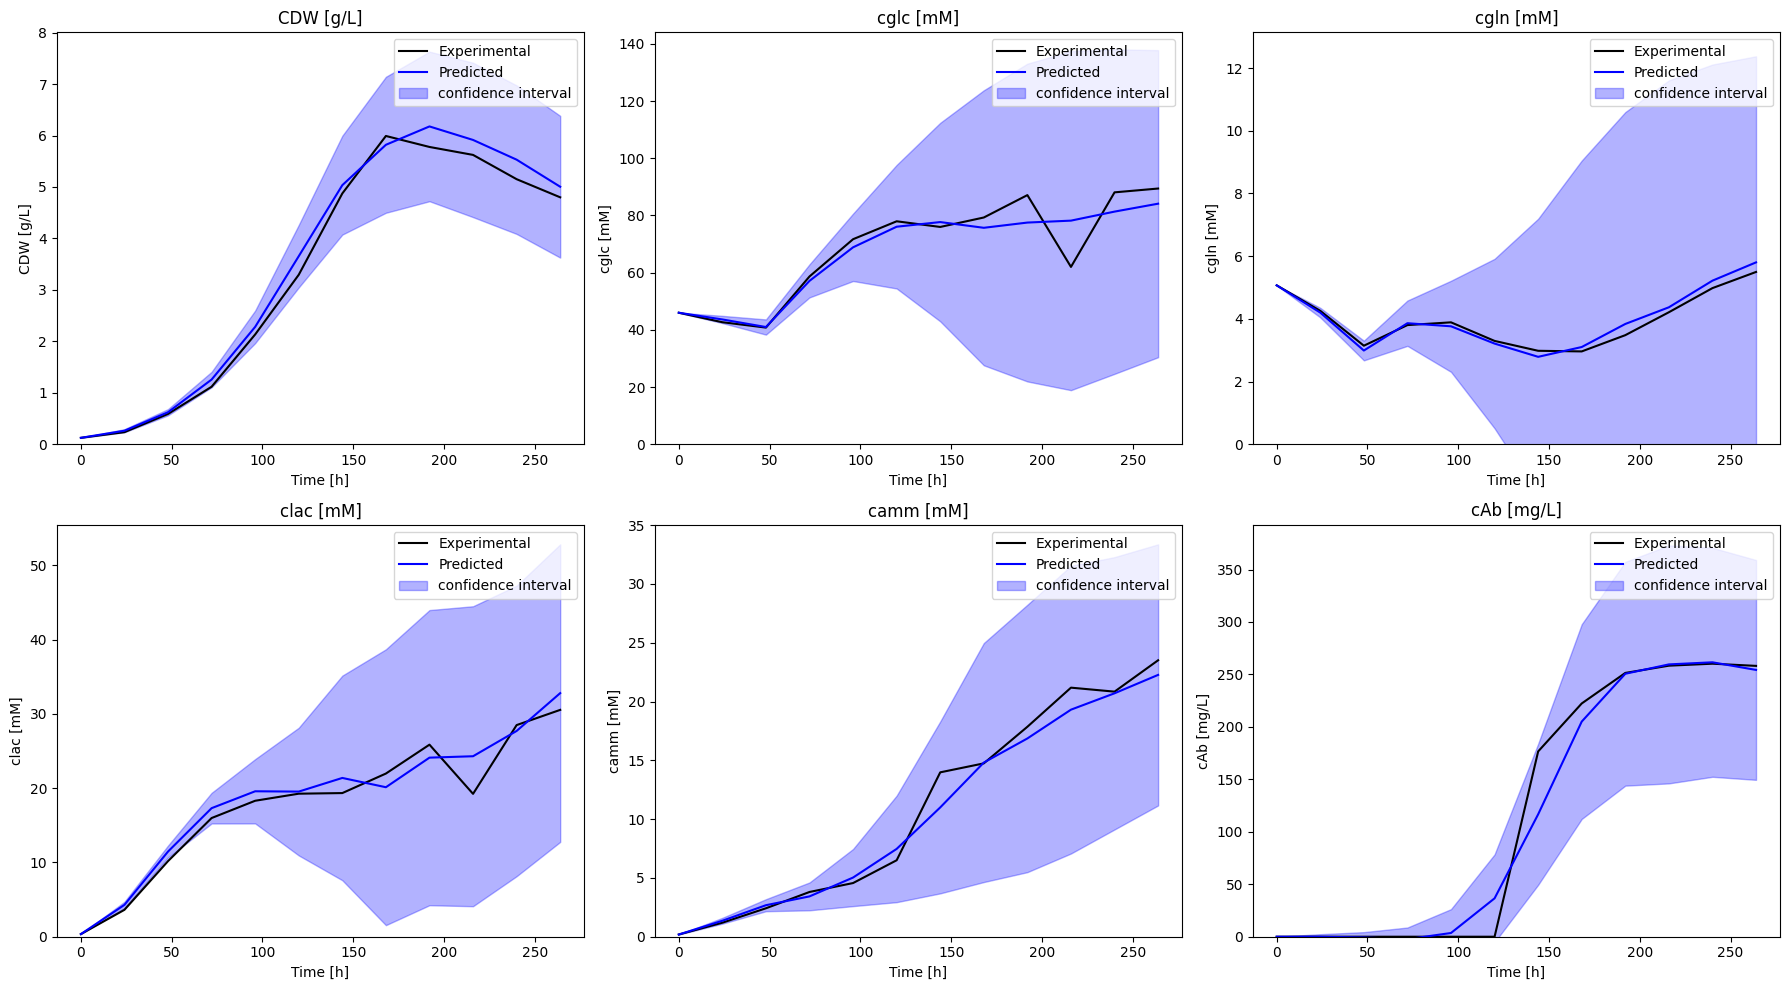

CDW [g/L] - MSE: 0.0549, NMSE: 0.010990415653792739
cglc [mM] - MSE: 38.2115, NMSE: 0.1302316417028525
cgln [mM] - MSE: 0.0344, NMSE: 0.05094565703847833
clac [mM] - MSE: 3.9612, NMSE: 0.050982656540775044
camm [mM] - MSE: 1.3628, NMSE: 0.019775074347570788
cAb [mg/L] - MSE: 438.8616, NMSE: 0.03004962542473978
Mean Mse : 80.41439672755455, mean nmse: 0.0488291784513682


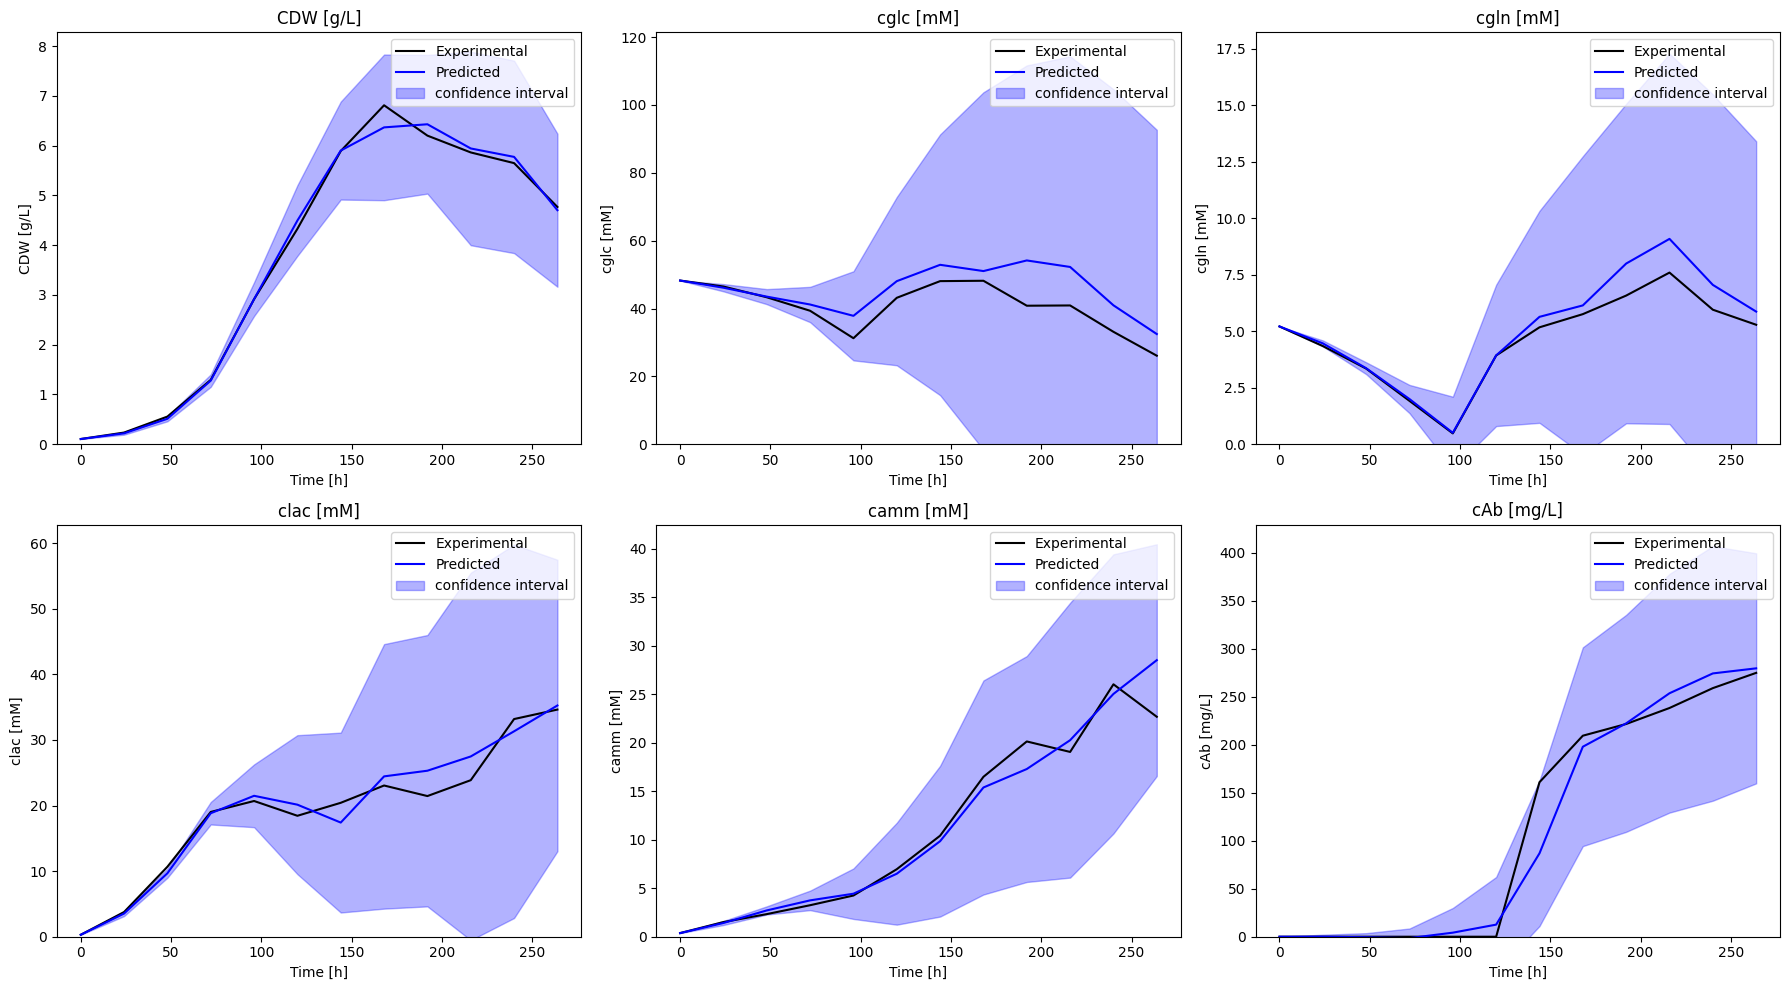

CDW [g/L] - MSE: 0.0255, NMSE: 0.004250926771951142
cglc [mM] - MSE: 42.5888, NMSE: 0.8877393901209119
cgln [mM] - MSE: 0.5133, NMSE: 0.14179694034022944
clac [mM] - MSE: 3.9576, NMSE: 0.041355754128476176
camm [mM] - MSE: 3.8963, NMSE: 0.049757660170516436
cAb [mg/L] - MSE: 524.4607, NMSE: 0.038565860987421124
Mean Mse : 95.9070464655844, mean nmse: 0.19391108875325103
Combined predictions saved to Operational Extrapolation__batchidx1_predicted_states.csv


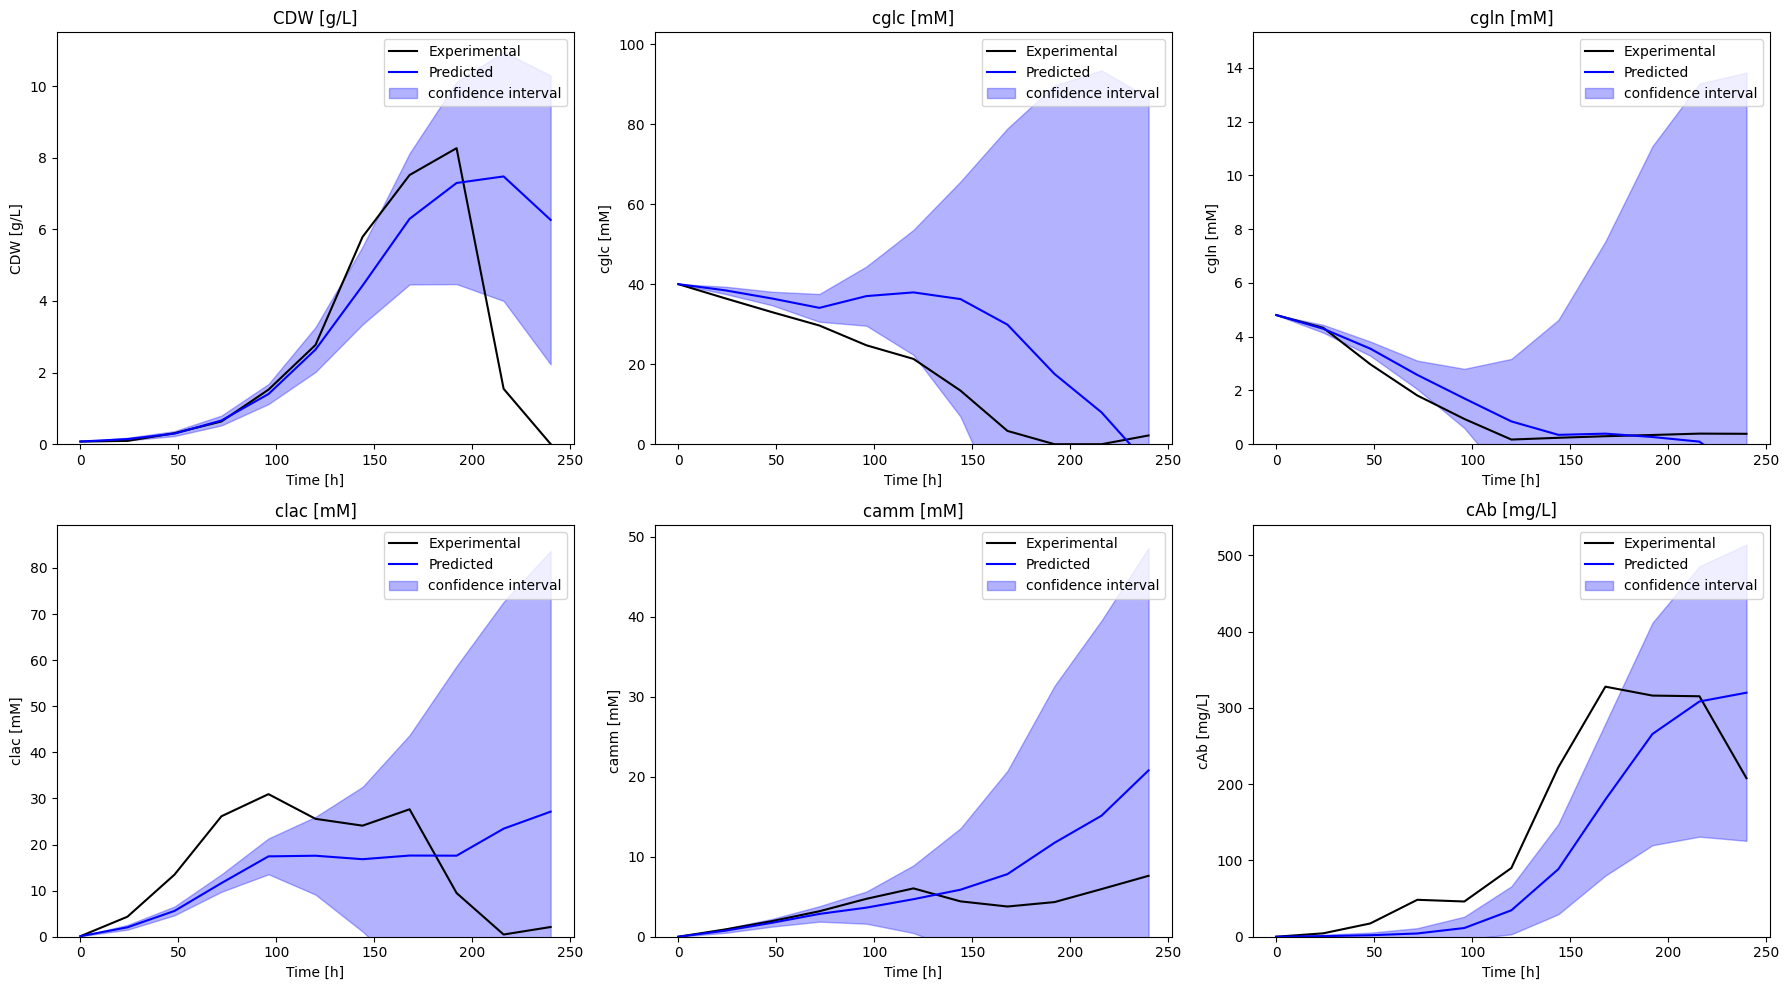

CDW [g/L] - MSE: 7.1518, NMSE: 0.8086622925581923
cglc [mM] - MSE: 192.3931, NMSE: 0.8922545947523007
cgln [mM] - MSE: 0.4133, NMSE: 0.15096854042618188
clac [mM] - MSE: 172.3501, NMSE: 1.283552750341454
camm [mM] - MSE: 30.4581, NMSE: 6.41012351507693
cAb [mg/L] - MSE: 5577.4194, NMSE: 0.3395213606463548
Mean Mse : 996.697611167258, mean nmse: 1.6475138423002356


In [25]:
idx = 1
evaluate_batch_category_gp_with_uncertainty(intrapolation_test_batches, "Intrapolation Test", trained_model, trained_likelihood, get_process_conditions_dict(intrapolation_test_ids), X_scalar, Y_scalar, idx=2)
evaluate_batch_category_gp_with_uncertainty(operational_extrapolation_batches, "Operational Extrapolation", trained_model, trained_likelihood, get_process_conditions_dict(operational_extrapolation_ids), X_scalar, Y_scalar, idx=idx, save_Data=True)
evaluate_batch_category_gp_with_uncertainty(initial_conc_extrapolation_batches, "Initial Concentration Extrapolation", trained_model, trained_likelihood, get_process_conditions_dict(initial_conc_extrapolation_ids), X_scalar, Y_scalar, idx=2)


### Simulation method 2
At each point use the experimental values for predicting the next time step

In [26]:
# Updated simulate_process_profile using multitask GP model
def simulate_process_profile_method_2(batch_data, times, process_conditions, model, likelihood, X_scalar, Y_scalar):
    # state_dim = len(initial_state)
    # Unpack process conditions
    initial_state = batch_data[0]
    feed_glc = process_conditions['cGlcF [mmol l-1]']
    feed_gln = process_conditions['cGlnF [mmol l-1]']
    feed_start_time = process_conditions['Feed start [days]'] * 24  # Convert to hours
    Feed_vol = process_conditions['F [ml day-1]'] * 0.001  # Convert to L/day
    predicted_states = [initial_state]
    predicted_states_lower = [initial_state]
    predicted_states_upper = [initial_state]
    predicted_stds = [np.zeros_like(initial_state)]
    initial_volume = initial_state[-1]  # Last element is volume
    volumes = [initial_volume]
    vol_tracker = False
    for i in range(1, len(times)):
        dt = times[i] - times[i-1]
        current_state = batch_data[i-1]
        current_volume = current_state[-1]
        t = times[i-1]

        
        x_input = np.concatenate([current_state, [
            process_conditions['cGlcF [mmol l-1]'],
            process_conditions['cGlnF [mmol l-1]'],
            process_conditions['Feed start [days]'],
            process_conditions['F [ml day-1]'],
            t
        ]])
        # find current feed volume:
        # compute feed volume and concentrations
        
        current_feed = 0
        # compute feed volume and concentrations
        if t>= feed_start_time:
            if vol_tracker == True:
                current_feed = 0
            elif current_volume + Feed_vol  > 0.051 :
                current_feed = 0.051- current_volume
                vol_tracker = True
            else:
                current_feed = Feed_vol
        x = np.concatenate([current_state, [current_feed], [feed_glc, feed_gln], [t]])

        # Predict next state using the GP model
        next_state, lower_bound, upper_bound, mean_reaction_rate = predict_with_gp(model, likelihood, x, X_scalar, Y_scalar)

        
        predicted_states.append(next_state)
        predicted_states_lower.append(lower_bound)
        predicted_states_upper.append(upper_bound)
        
        volumes.append(next_state[-1])

    return np.array(predicted_states), np.array(predicted_states_lower), np.array(predicted_states_upper)

In [27]:
# Predict complete process for a batch
def evaluate_batch_category_gp_with_uncertainty_method_2(test_batches, category_name, model, likelihood, process_conditions_dict, X_scalar, Y_scalar, idx=0, save_Data = False):
    state_vars = ['CDW [g/L]', 'cglc [mM]', 'cgln [mM]', 'clac [mM]', 'camm [mM]', 'cAb [mg/L]', 'V [L]']
    first_batch_id = list(test_batches.keys())[idx]
    df = test_batches[first_batch_id]
    times = df['time [h]'].values
    true_states = df[state_vars].values
    initial_state = true_states[0]
    # initial_volume = df['V [L]'].values[0]
    process_conditions = process_conditions_dict[first_batch_id]

    predicted_states, predicted_states_lower, predicted_states_upper = simulate_process_profile_method_2(true_states, times, process_conditions, model, likelihood, X_scalar, Y_scalar)
    
    plot_process_profiles(times, predicted_states, predicted_states_lower, predicted_states_upper, true_states, state_vars[:-1], title = category_name) # exclude volume from plots

    for i, var in enumerate(state_vars[:-1]):
        mse = mean_squared_error(true_states[:, i], predicted_states[:, i])
        print(f"{var} - MSE: {mse:.4f}")
    
    if save_Data:
        # Save predicted states to a CSV file
        output_df = pd.DataFrame(predicted_states, columns=state_vars)
        output_df['time [h]'] = times
        output_df.to_csv(f"{category_name}_batchidx{idx}_predicted_states.csv", index=False)
        print(f"Predicted states saved to {category_name}__batchidx{idx}_predicted_states.csv")

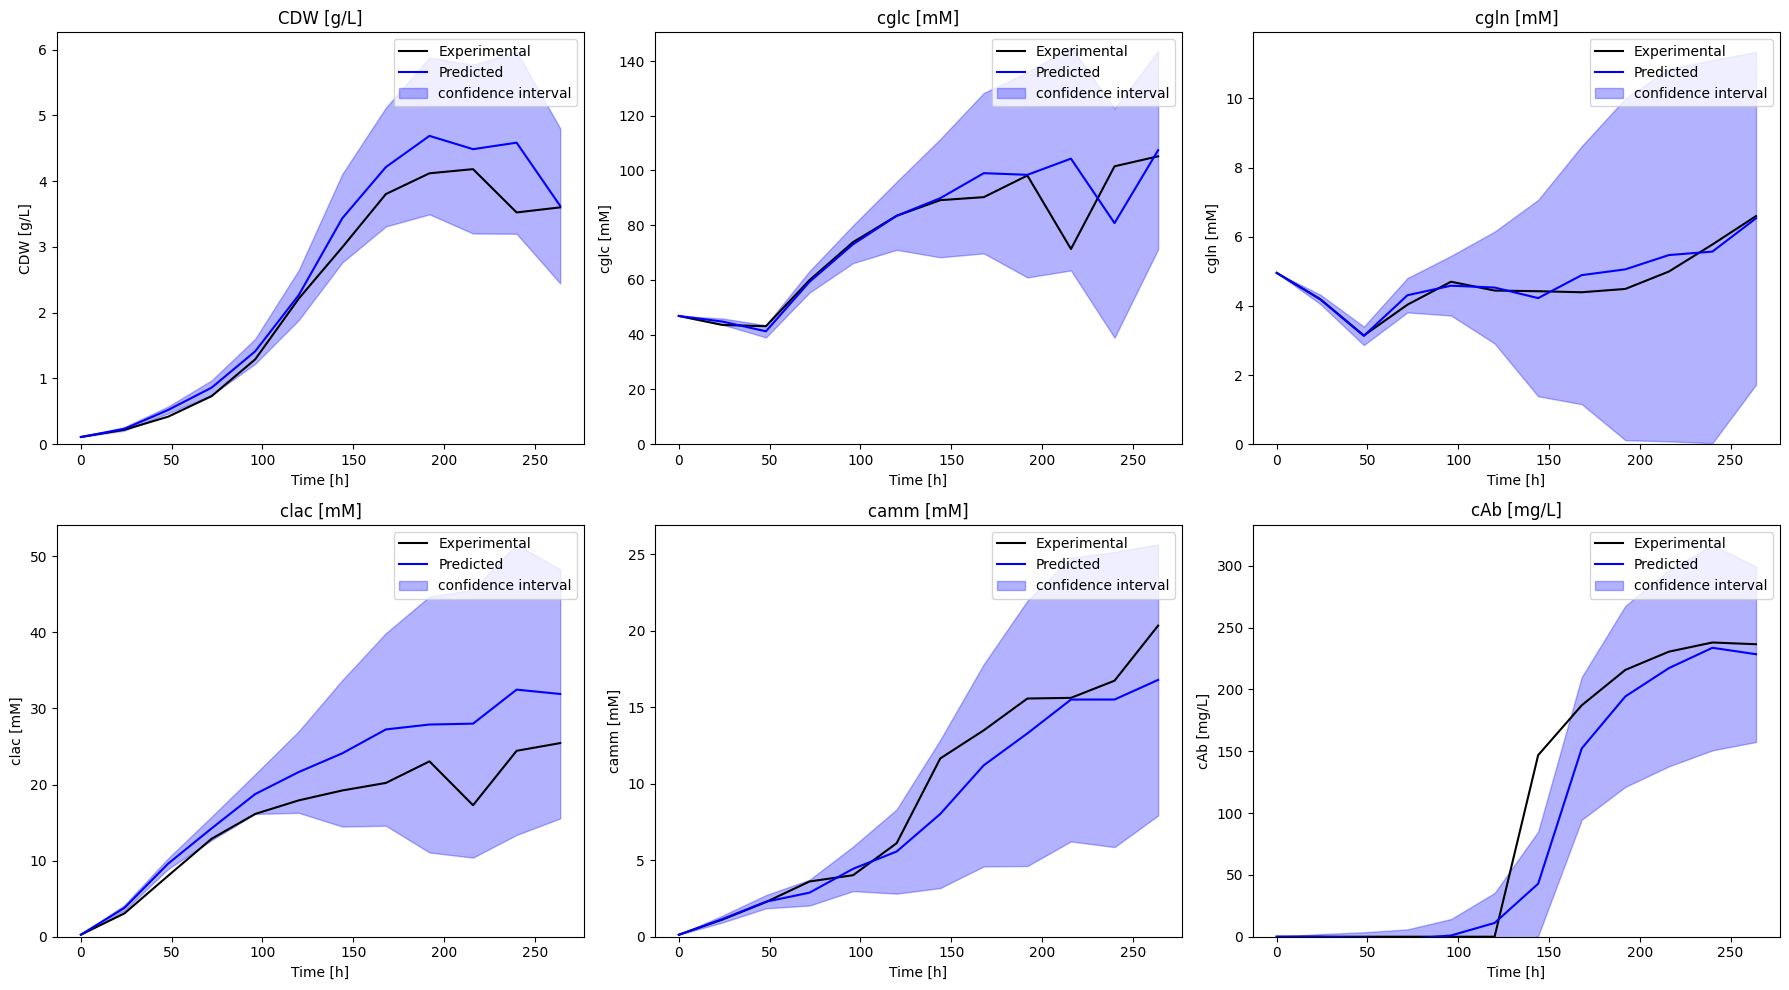

CDW [g/L] - MSE: 0.1625
cglc [mM] - MSE: 134.0197
cgln [mM] - MSE: 0.0811
clac [mM] - MSE: 28.6193
camm [mM] - MSE: 3.2271
cAb [mg/L] - MSE: 1073.5708


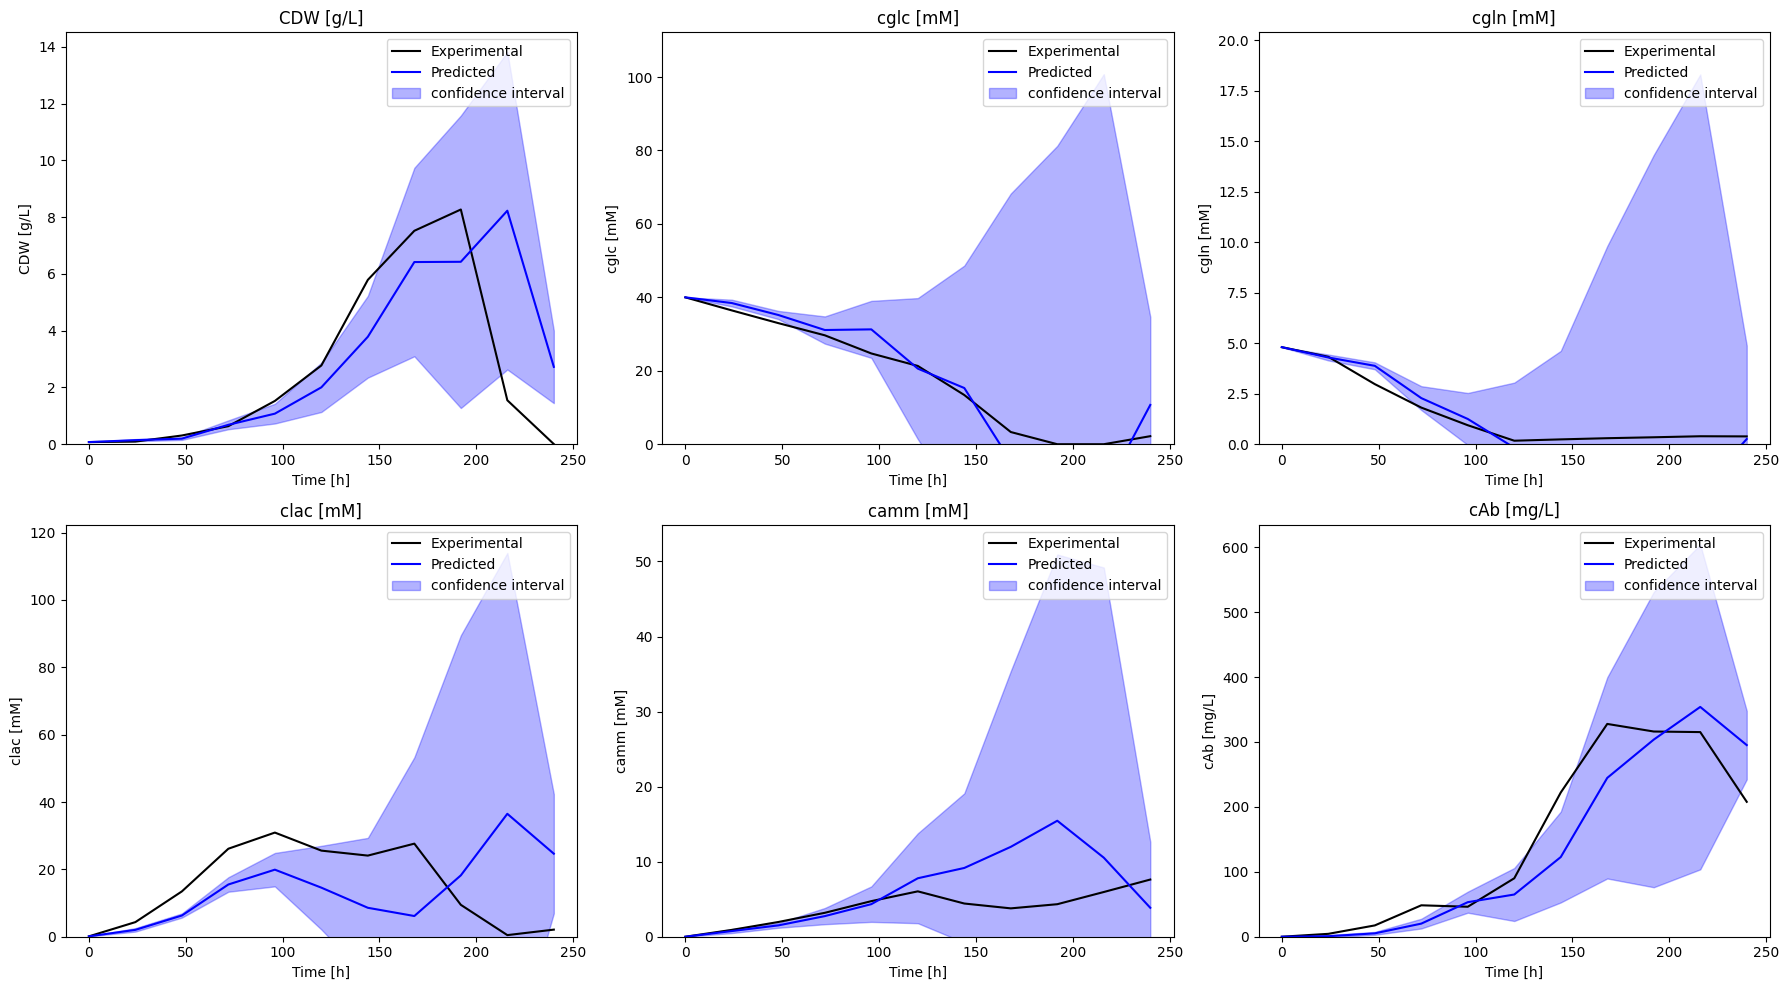

CDW [g/L] - MSE: 5.5824
cglc [mM] - MSE: 80.8464
cgln [mM] - MSE: 3.7777
clac [mM] - MSE: 272.3737
camm [mM] - MSE: 22.9213
cAb [mg/L] - MSE: 2520.3315


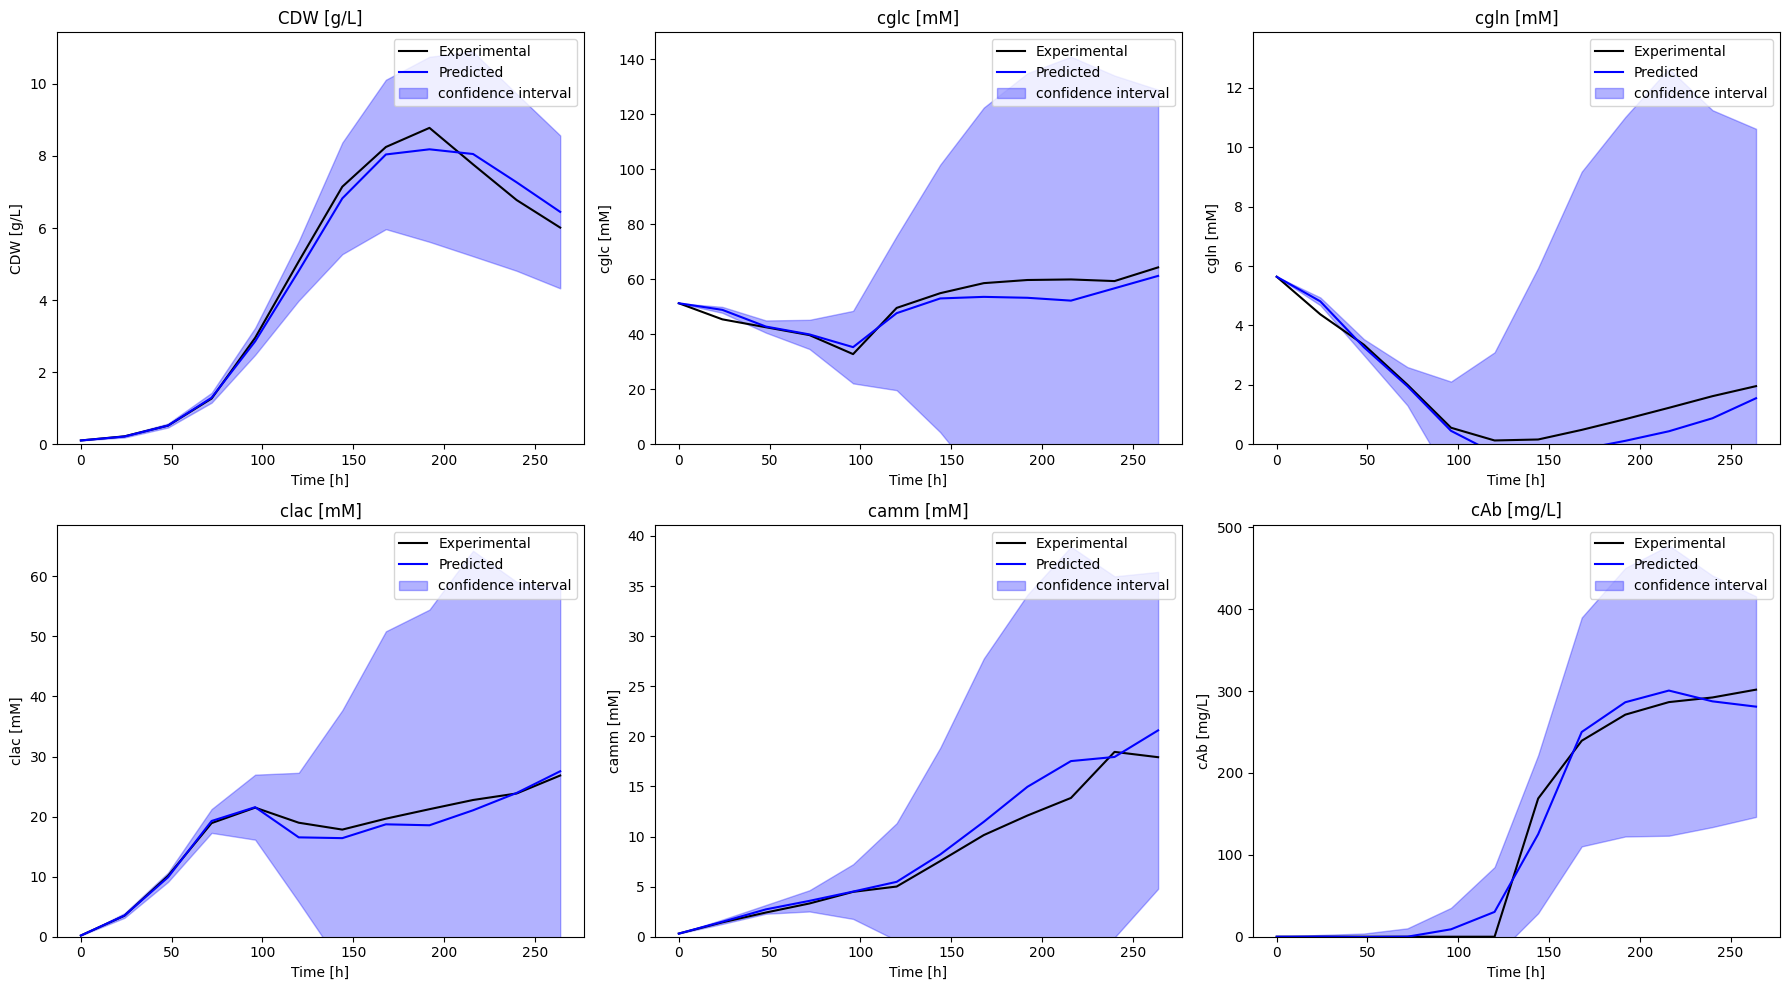

CDW [g/L] - MSE: 0.0914
cglc [mM] - MSE: 14.0132
cgln [mM] - MSE: 0.2330
clac [mM] - MSE: 1.6377
camm [mM] - MSE: 2.6467
cAb [mg/L] - MSE: 324.5902
Predicted states saved to Initial Concentration Extrapolation__batchidx3_predicted_states.csv


In [28]:
idx =0
evaluate_batch_category_gp_with_uncertainty_method_2(intrapolation_test_batches, "Intrapolation Test", trained_model, trained_likelihood, get_process_conditions_dict(intrapolation_test_ids), X_scalar, Y_scalar, idx=idx)
evaluate_batch_category_gp_with_uncertainty_method_2(operational_extrapolation_batches, "Operational Extrapolation", trained_model, trained_likelihood, get_process_conditions_dict(operational_extrapolation_ids), X_scalar, Y_scalar, idx=idx)
evaluate_batch_category_gp_with_uncertainty_method_2(initial_conc_extrapolation_batches, "Initial Concentration Extrapolation", trained_model, trained_likelihood, get_process_conditions_dict(initial_conc_extrapolation_ids), X_scalar, Y_scalar, idx=3, save_Data=True)
